In [1]:
import tensorflow as tf

# tfra does some patching on tensorflow so MUST be imported after importing tf
import tensorflow_recommenders as tfrs
import tensorflow_recommenders_addons as tfra
import tensorflow_recommenders_addons.dynamic_embedding as de
import tensorflow_datasets as tfds

import functools
from typing import Dict
import dataclasses
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2023-04-03 22:37:04.962349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 22:37:04.963895: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.3


## Download datasets

In [4]:
# https://www.tensorflow.org/datasets/catalog/movielens
# Interactions dataset
raw_ratings_dataset = tfds.load("movielens/1m-ratings", split="train")
# Candidates dataset
raw_movies_dataset = tfds.load("movielens/1m-movies", split="train")

2023-04-03 22:37:50.014458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 22:37:50.015554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 22:37:50.016298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-03 22:37:50.016479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-03 22:37:50.017071: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [5]:
df = tfds.as_dataframe(raw_ratings_dataset.take(100))
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,35.0,"[0, 7]",b'3107',b'Backdraft (1991)',977432193,True,b'130',18,b'technician/engineer',5.0,b'50021'
1,25.0,[7],b'2114',"b'Outsiders, The (1983)'",965932967,False,b'3829',0,b'academic/educator',4.0,b'22307'
2,18.0,"[4, 15]",b'256',b'Junior (1994)',1012103552,False,b'1265',21,b'writer',1.0,b'49321'
3,18.0,"[0, 10]",b'1389',b'Jaws 3-D (1983)',972004605,True,b'2896',14,b'sales/marketing',5.0,b'60073'
4,18.0,[0],b'3635',"b'Spy Who Loved Me, The (1977)'",961180111,True,b'5264',17,b'college/grad student',4.0,b'15217'


In [6]:
for item in raw_ratings_dataset.take(1):
    print(item)

{'bucketized_user_age': <tf.Tensor: shape=(), dtype=float32, numpy=35.0>, 'movie_genres': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 7])>, 'movie_id': <tf.Tensor: shape=(), dtype=string, numpy=b'3107'>, 'movie_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Backdraft (1991)'>, 'timestamp': <tf.Tensor: shape=(), dtype=int64, numpy=977432193>, 'user_gender': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'130'>, 'user_occupation_label': <tf.Tensor: shape=(), dtype=int64, numpy=18>, 'user_occupation_text': <tf.Tensor: shape=(), dtype=string, numpy=b'technician/engineer'>, 'user_rating': <tf.Tensor: shape=(), dtype=float32, numpy=5.0>, 'user_zip_code': <tf.Tensor: shape=(), dtype=string, numpy=b'50021'>}


## Processing datasets

In [7]:
max_token_length = 6
pad_token = "[PAD]"
punctuation_regex = "[\!\"#\$%&\(\)\*\+,-\.\/\:;\<\=\>\?@\[\]\\\^_`\{\|\}~\\t\\n]"

def process_text(x: tf.Tensor, max_token_length: int, punctuation_regex: str) -> tf.Tensor:
    
    return tf.strings.split(
        tf.strings.regex_replace(
            tf.strings.lower(x["movie_title"]), punctuation_regex, ""
        )
    )[:max_token_length]


def process_ratings_dataset(ratings_dataset: tf.data.Dataset) -> tf.data.Dataset:
    
    partial_process_text = functools.partial(
        process_text, max_token_length=max_token_length, punctuation_regex=punctuation_regex
    )

    preprocessed_movie_title_dataset = ratings_dataset.map(
        lambda x: partial_process_text(x)
    )

    processed_dataset = tf.data.Dataset.zip(
        (ratings_dataset, preprocessed_movie_title_dataset)
    ).map(
        lambda x,y: {"user_id": x["user_id"]} | {"movie_title": y}
    )
    
    return processed_dataset


def process_movies_dataset(movies_dataset: tf.data.Dataset) -> tf.data.Dataset:
    
    partial_process_text = functools.partial(
        process_text, max_token_length=max_token_length, punctuation_regex=punctuation_regex
    )
    
    processed_dataset = raw_movies_dataset.map(
        lambda x: partial_process_text(x)
    )
    
    return processed_dataset

processed_ratings_dataset = process_ratings_dataset(raw_ratings_dataset)
for item in processed_ratings_dataset.take(3):
    print(item)

{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'130'>, 'movie_title': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'backdraft', b'1991'], dtype=object)>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'3829'>, 'movie_title': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'outsiders', b'the', b'1983'], dtype=object)>}
{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1265'>, 'movie_title': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'junior', b'1994'], dtype=object)>}


In [8]:
batch_size=4096
seed=2023
train_size = int(len(processed_ratings_dataset) * 0.9)
validation_size = len(processed_ratings_dataset) - train_size
print(f"Train size: {train_size}")
print(f"Validation size: {validation_size}")

# Things we're not considering
# out of sample validation
# out of time validation

@dataclasses.dataclass(frozen=True)
class TrainingDatasets:
    train_ds: tf.data.Dataset
    validation_ds: tf.data.Dataset

@dataclasses.dataclass(frozen=True)
class RetrievalDatasets:
    training_datasets: TrainingDatasets
    candidate_dataset: tf.data.Dataset

def pad_and_batch_ratings_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    
    return dataset.padded_batch(
        batch_size, 
        padded_shapes={
            "user_id": tf.TensorShape([]),
            "movie_title": tf.TensorShape([max_token_length,])
        }, padding_values={
            "user_id": pad_token, 
            "movie_title": pad_token
        }
    )
    
        
def split_train_validation_datasets(ratings_dataset: tf.data.Dataset) -> TrainingDatasets:
    
    shuffled_dataset = ratings_dataset.shuffle(buffer_size=5*batch_size, seed=seed)
    train_ds = shuffled_dataset.skip(validation_size).shuffle(buffer_size=10*batch_size).apply(pad_and_batch_ratings_dataset)
    validation_ds = shuffled_dataset.take(validation_size).apply(pad_and_batch_ratings_dataset)
    
    return TrainingDatasets(train_ds=train_ds, validation_ds=validation_ds)

def pad_and_batch_candidate_dataset(movies_dataset: tf.data.Dataset) -> tf.data.Dataset:
    return movies_dataset.padded_batch(
        batch_size, 
        padded_shapes=tf.TensorShape([max_token_length,]), 
        padding_values=pad_token
    )

def create_datasets() -> RetrievalDatasets:
    
    raw_ratings_dataset = tfds.load("movielens/1m-ratings", split="train")
    raw_movies_dataset = tfds.load("movielens/1m-movies", split="train")
    
    processed_ratings_dataset = process_ratings_dataset(raw_ratings_dataset)
    processed_movies_dataset = process_movies_dataset(raw_movies_dataset)

    training_datasets = split_train_validation_datasets(processed_ratings_dataset)
    candidate_dataset = pad_and_batch_candidate_dataset(processed_movies_dataset)
    
    return RetrievalDatasets(training_datasets=training_datasets, candidate_dataset=candidate_dataset)

datasets = create_datasets()
print(f"Train dataset size (after batching): {len(datasets.training_datasets.train_ds)}")
print(f"Validation dataset size (after batching): {len(datasets.training_datasets.validation_ds)}")

Train size: 900188
Validation size: 100021
Train dataset size (after batching): 220
Validation dataset size (after batching): 25


## Defining user and item towers

In [9]:
def get_user_id_lookup_layer(dataset: tf.data.Dataset) -> tf.keras.layers.Layer:
    user_lookup_layer = tf.keras.layers.StringLookup(mask_token=None)
    user_lookup_layer.adapt(dataset.map(lambda x: x["user_id"]))
    return user_lookup_layer

def build_user_model(user_id_lookup_layer: tf.keras.layers.StringLookup):
    vocab_size = user_id_lookup_layer.vocabulary_size()
    return tf.keras.Sequential([
        # Fix from https://github.com/keras-team/keras/issues/16101
        tf.keras.layers.InputLayer(input_shape=(), dtype=tf.string),
        user_id_lookup_layer, 
        tf.keras.layers.Embedding(vocab_size, 64), 
        tf.keras.layers.Dense(64, activation="gelu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        
    ], name='user_model')


In [10]:
def get_movie_title_lookup_layer(dataset: tf.data.Dataset) -> tf.keras.layers.Layer:
    movie_title_lookup_layer = tf.keras.layers.StringLookup(mask_token=pad_token)
    movie_title_lookup_layer.adapt(dataset.map(lambda x: x["movie_title"]))
    return movie_title_lookup_layer

def build_item_model(movie_title_lookup_layer: tf.keras.layers.StringLookup):
    vocab_size = movie_title_lookup_layer.vocabulary_size()
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_token_length), dtype=tf.string),
        movie_title_lookup_layer, 
        tf.keras.layers.Embedding(vocab_size, 64), 
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation="gelu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ])

## Testing the lookup layers

In [9]:
# TODO: example models
user_id_lookup_layer = get_user_id_lookup_layer(datasets.training_datasets.train_ds)
print(f"Vocabulary size (user_id): {len(user_id_lookup_layer.get_vocabulary())}")

movie_title_lookup_layer = get_movie_title_lookup_layer(datasets.training_datasets.train_ds)
print(f"Vocabulary size (movie_title): {len(movie_title_lookup_layer.get_vocabulary())}")

Vocabulary size (user_id): 6041
Vocabulary size (movie_title): 4294


## Defining the two tower model (without dynamic embeddings)

In [10]:
class TwoTowerModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

    def __init__(self,user_model: tf.keras.Model,item_model: tf.keras.Model,task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie representations.
        self.user_model = user_model
        self.item_model = item_model
        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Define how the loss is computed.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.item_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)


## Creating the model

In [11]:
def create_two_tower_model(dataset: tf.data.Dataset, candidate_dataset: tf.data.Dataset) -> tf.keras.Model:
    user_id_lookup_layer = get_user_id_lookup_layer(dataset)
    movie_title_lookup_layer = get_movie_title_lookup_layer(dataset)
    user_model = build_user_model(user_id_lookup_layer)
    item_model = build_item_model(movie_title_lookup_layer)
    task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidate_dataset.map(item_model)
        ),
    )

    model = TwoTowerModel(user_model, item_model, task)
    model.compile(optimizer=tf.keras.optimizers.Adam())
    
    return model

datasets = create_datasets()
model = create_two_tower_model(datasets.training_datasets.train_ds, datasets.candidate_dataset)

## Training the model

In [12]:
# Train for 3 epochs.

history = model.fit(datasets.training_datasets.train_ds, epochs=3, validation_data=datasets.training_datasets.validation_ds)

Epoch 1/3
220/220 [==============================] - 159s 689ms/step - factorized_top_k/top_1_categorical_accuracy: 4.0880e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0034 - factorized_top_k/top_10_categorical_accuracy: 0.0071 - factorized_top_k/top_50_categorical_accuracy: 0.0325 - factorized_top_k/top_100_categorical_accuracy: 0.0597 - loss: 33607.3019 - regularization_loss: 0.0000e+00 - total_loss: 33607.3019 - val_factorized_top_k/top_1_categorical_accuracy: 0.0010 - val_factorized_top_k/top_5_categorical_accuracy: 0.0070 - val_factorized_top_k/top_10_categorical_accuracy: 0.0137 - val_factorized_top_k/top_50_categorical_accuracy: 0.0595 - val_factorized_top_k/top_100_categorical_accuracy: 0.1069 - val_loss: 12435.4785 - val_regularization_loss: 0.0000e+00 - val_total_loss: 12435.4785
Epoch 2/3
220/220 [==============================] - 166s 720ms/step - factorized_top_k/top_1_categorical_accuracy: 9.3092e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factoriz

In [13]:
history_standard = history.history

## Using `Embedding` layer from `dynamic_embedding`

Defining user tower and iterm tower with dynamic embeddings

In [2]:
tf.compat.v1.reset_default_graph()

def build_de_user_model(user_id_lookup_layer: tf.keras.layers.StringLookup) -> tf.keras.layers.Layer:
    vocab_size = user_id_lookup_layer.vocabulary_size()
    return tf.keras.Sequential([
        # Fix from https://github.com/keras-team/keras/issues/16101
        tf.keras.layers.InputLayer(input_shape=(), dtype=tf.string),
        user_id_lookup_layer, 
        de.keras.layers.Embedding(
            embedding_size=64,
            initializer=tf.random_uniform_initializer(),
            init_capacity=int(vocab_size*0.8), 
            restrict_policy=de.FrequencyRestrictPolicy,
            name="UserDynamicEmbeddingLayer"
        ), 
        tf.keras.layers.Dense(64, activation="gelu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        
    ], name='user_model')

def build_de_item_model(movie_title_lookup_layer: tf.keras.layers.StringLookup) -> tf.keras.layers.Layer:
    vocab_size = movie_title_lookup_layer.vocabulary_size()
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_token_length), dtype=tf.string),
        movie_title_lookup_layer, 
        de.keras.layers.SquashedEmbedding(
            embedding_size=64,
            initializer=tf.random_uniform_initializer(),
            init_capacity=int(vocab_size*0.8), 
            restrict_policy=de.FrequencyRestrictPolicy,
            combiner="mean",
            name="ItemDynamicEmbeddingLayer"
        ),
        tf.keras.layers.Dense(64, activation="gelu"),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ])

## Defining the callback to control and log dynamic embeddings

In [3]:
class DynamicEmbeddingCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, model, steps_per_logging, steps_per_restrict=None, restrict=False):
        self.model = model
        self.steps_per_logging = steps_per_logging
        self.steps_per_restrict = steps_per_restrict
        self.restrict = restrict
    
    def on_train_begin(self, logs=None):
        self.model.dynamic_embedding_history = {}
        
    def on_train_batch_end(self, batch, logs=None):
                
        if self.restrict and self.steps_per_restrict and (batch+1) % self.steps_per_restrict == 0:
            
            [
                self.model.embedding_layers[k].params.restrict(
                    int(self.model.lookup_vocab_sizes[k]*0.8), 
                    trigger=self.model.lookup_vocab_sizes[k]-2 # UNK & PAD tokens
                ) for k in self.model.embedding_layers.keys()
            ] 
        
        if (batch+1) % self.steps_per_logging == 0:
            
            embedding_size_dict = {
                k:self.model.embedding_layers[k].params.size().numpy() 
                for k in self.model.embedding_layers.keys()
            }

            for k, v in embedding_size_dict.items():
                self.model.dynamic_embedding_history.setdefault(f"embedding_size_{k}", []).append(v)
            self.model.dynamic_embedding_history.setdefault(f"step", []).append(batch+1)
            

## Defining two tower model with dynamic embeddings

In [11]:
class DynamicEmbeddingTwoTowerModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

    def __init__(self,user_model: tf.keras.Model,item_model: tf.keras.Model,task: tfrs.tasks.Retrieval):
        super().__init__()

        # Set up user and movie representations.
        self.user_model = user_model
        self.item_model = item_model
        
        self.embedding_layers = {
            "user": user_model.layers[1], 
            "movie": item_model.layers[1]
        }
        
        if not all(["embedding" in v.name.lower() for k,v in self.embedding_layers.items()]):
            raise TypeError(
                f"""All layers in embedding_layers must be embedding layers.
                Got {[v.name for v in self.embedding_layers.values()]}"""
            )
            
        self.lookup_vocab_sizes = {
            "user": user_model.layers[0].vocabulary_size(), 
            "movie": item_model.layers[0].vocabulary_size()
        }
        self.dynamic_embedding_history = {}
        # Set up a retrieval task.
        self.task = task

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Define how the loss is computed.
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.item_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)


In [12]:
def create_de_two_tower_model(dataset: tf.data.Dataset, candidate_dataset: tf.data.Dataset) -> tf.keras.Model:
    
    user_id_lookup_layer = get_user_id_lookup_layer(dataset)
    movie_title_lookup_layer = get_movie_title_lookup_layer(dataset)
    user_model = build_de_user_model(user_id_lookup_layer)
    item_model = build_de_item_model(movie_title_lookup_layer)
    task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidate_dataset.map(item_model)
        ),
    )

    model = DynamicEmbeddingTwoTowerModel(user_model, item_model, task)
    optimizer = de.DynamicEmbeddingOptimizer(tf.keras.optimizers.Adam())
    model.compile(optimizer=optimizer)
    
    return model

datasets = create_datasets()
de_model = create_de_two_tower_model(datasets.training_datasets.train_ds, datasets.candidate_dataset)

2023-04-03 22:38:26.783370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 34749 of 40960
2023-04-03 22:38:27.186988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-04-03 22:39:30.453738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 39970 of 40960
2023-04-03 22:39:30.515715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-04-03 22:40:19.388437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-03 22:40:19.388571: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https:

## Training the model with dynamic embeddings

In [18]:
epochs = 3

history_de = {}
history_de_size = {}
de_callback = DynamicEmbeddingCallback(de_model, steps_per_logging=20)

for epoch in range(epochs):

    datasets = create_datasets()
    train_steps = len(datasets.training_datasets.train_ds)
    
    hist = de_model.fit(
        datasets.training_datasets.train_ds, 
        epochs=1, 
        validation_data=datasets.training_datasets.validation_ds, 
        callbacks=[de_callback]
    )
    
    for k,v in de_model.dynamic_embedding_history.items():
        if k=="step":
            v = [vv+(epoch*train_steps) for vv in v]
        history_de_size.setdefault(k, []).extend(v)
        
    for k,v in hist.history.items():
        history_de.setdefault(k, []).extend(v)

2023-03-27 06:15:45.229098: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=64, init_size=4832
2023-03-27 06:15:45.232571: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=64, init_size=3435
2023-03-27 06:15:45.242801: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=64, init_size=4832
2023-03-27 06:15:45.250305: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=64, init_size=3435


220/220 [==============================] - 163s 709ms/step - factorized_top_k/top_1_categorical_accuracy: 9.8202e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0079 - factorized_top_k/top_10_categorical_accuracy: 0.0161 - factorized_top_k/top_50_categorical_accuracy: 0.0721 - factorized_top_k/top_100_categorical_accuracy: 0.1269 - loss: 32986.5514 - regularization_loss: 0.0000e+00 - total_loss: 32986.5514 - val_factorized_top_k/top_1_categorical_accuracy: 0.0011 - val_factorized_top_k/top_5_categorical_accuracy: 0.0077 - val_factorized_top_k/top_10_categorical_accuracy: 0.0159 - val_factorized_top_k/top_50_categorical_accuracy: 0.0699 - val_factorized_top_k/top_100_categorical_accuracy: 0.1243 - val_loss: 12334.5811 - val_regularization_loss: 0.0000e+00 - val_total_loss: 12334.5811


## Training the model with dynamic embeddings (streaming with restrict)

In [19]:
tf.compat.v1.reset_default_graph()

datasets = create_datasets()
de_model = create_de_two_tower_model(datasets.training_datasets.train_ds, datasets.candidate_dataset)

epochs = 3

history_de_restrict = {}
history_de_size_restrict = {}
de_callback = DynamicEmbeddingCallback(de_model, steps_per_logging=20, steps_per_restrict=220, restrict=True)

for epoch in range(epochs):

    datasets = create_datasets()
    train_steps = len(datasets.training_datasets.train_ds)
    
    hist = de_model.fit(
        datasets.training_datasets.train_ds, 
        epochs=1, 
        validation_data=datasets.training_datasets.validation_ds, 
        callbacks=[de_callback]
    )
    
    for k,v in de_model.dynamic_embedding_history.items():
        if k=="step":
            v = [vv+(epoch*train_steps) for vv in v]
        history_de_size_restrict.setdefault(k, []).extend(v)
        
    for k,v in hist.history.items():
        history_de_restrict.setdefault(k, []).extend(v)

2023-03-27 06:25:24.033027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 06:25:24.033162: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-27 06:25:24.034944: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optimized mode: K=l, V=i, DIM=1, init_size=4832
2023-03-27 06:25:24.037935: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:157] HashTable on CPU is created on optim

220/220 [==============================] - 160s 684ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0171 - factorized_top_k/top_50_categorical_accuracy: 0.0732 - factorized_top_k/top_100_categorical_accuracy: 0.1278 - loss: 32981.5708 - regularization_loss: 0.0000e+00 - total_loss: 32981.5708 - val_factorized_top_k/top_1_categorical_accuracy: 0.0010 - val_factorized_top_k/top_5_categorical_accuracy: 0.0078 - val_factorized_top_k/top_10_categorical_accuracy: 0.0162 - val_factorized_top_k/top_50_categorical_accuracy: 0.0684 - val_factorized_top_k/top_100_categorical_accuracy: 0.1205 - val_loss: 12357.4219 - val_regularization_loss: 0.0000e+00 - val_total_loss: 12357.4219


## Plotting accuracies

Text(0.5, 1.0, 'Model accuracy with and wo dynamic embeddings')

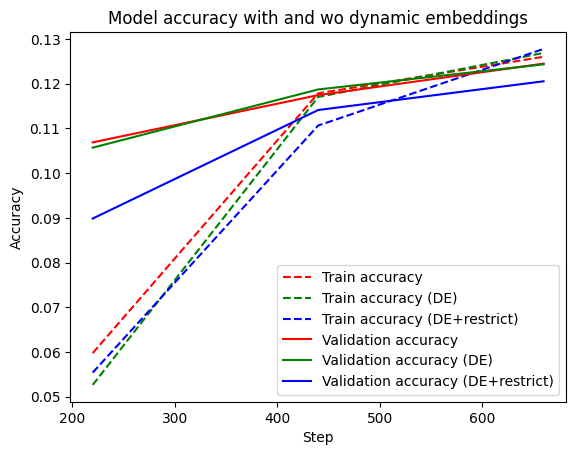

In [20]:
steps = [(epoch+1)*train_steps for epoch in range(epochs)]
plt.plot(steps, history_standard["factorized_top_k/top_100_categorical_accuracy"], color="r", linestyle="--", label="Train accuracy")
plt.plot(steps, history_de["factorized_top_k/top_100_categorical_accuracy"], color="g", linestyle="--", label="Train accuracy (DE)")
plt.plot(steps, history_de_restrict["factorized_top_k/top_100_categorical_accuracy"], color="b", linestyle="--", label="Train accuracy (DE+restrict)")
plt.plot(steps, history_standard["val_factorized_top_k/top_100_categorical_accuracy"], color="r", label="Validation accuracy")
plt.plot(steps, history_de["val_factorized_top_k/top_100_categorical_accuracy"], color="g", label="Validation accuracy (DE)")
plt.plot(steps, history_de_restrict["val_factorized_top_k/top_100_categorical_accuracy"], color="b", label="Validation accuracy (DE+restrict)")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Model accuracy with and wo dynamic embeddings")

## Plotting embedding sizes

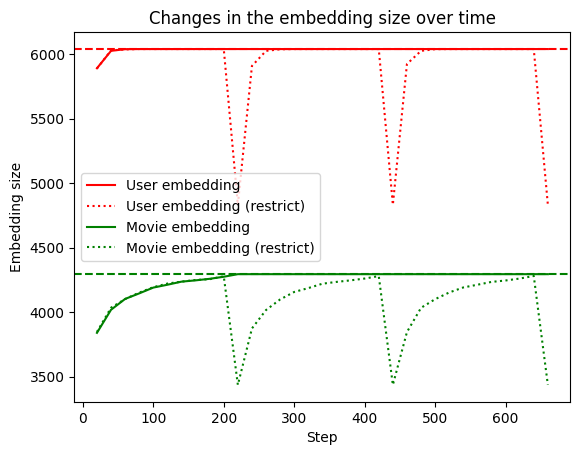

In [21]:
steps = history_de_size["step"]
plt.plot(steps, history_de_size["embedding_size_user"], color="r", label="User embedding")
plt.plot(steps, history_de_size_restrict["embedding_size_user"], color="r", linestyle=":", label="User embedding (restrict)")
plt.axhline(de_model.lookup_vocab_sizes["user"], color="r", linestyle="--")
plt.plot(steps, history_de_size["embedding_size_movie"], color="g", label="Movie embedding")
plt.plot(steps, history_de_size_restrict["embedding_size_movie"], color="g", linestyle=":", label="Movie embedding (restrict)")
plt.axhline(de_model.lookup_vocab_sizes["movie"], color="g", linestyle="--")
plt.ylabel("Embedding size")
plt.xlabel("Step")
plt.title("Changes in the embedding size over time")
plt.legend()
plt.show()

## Some EDA

count    100000.000000
mean          3.902200
std           1.728747
min           2.000000
50%           3.000000
90%           6.000000
max          15.000000
Name: movie_title, dtype: float64


<Axes: >

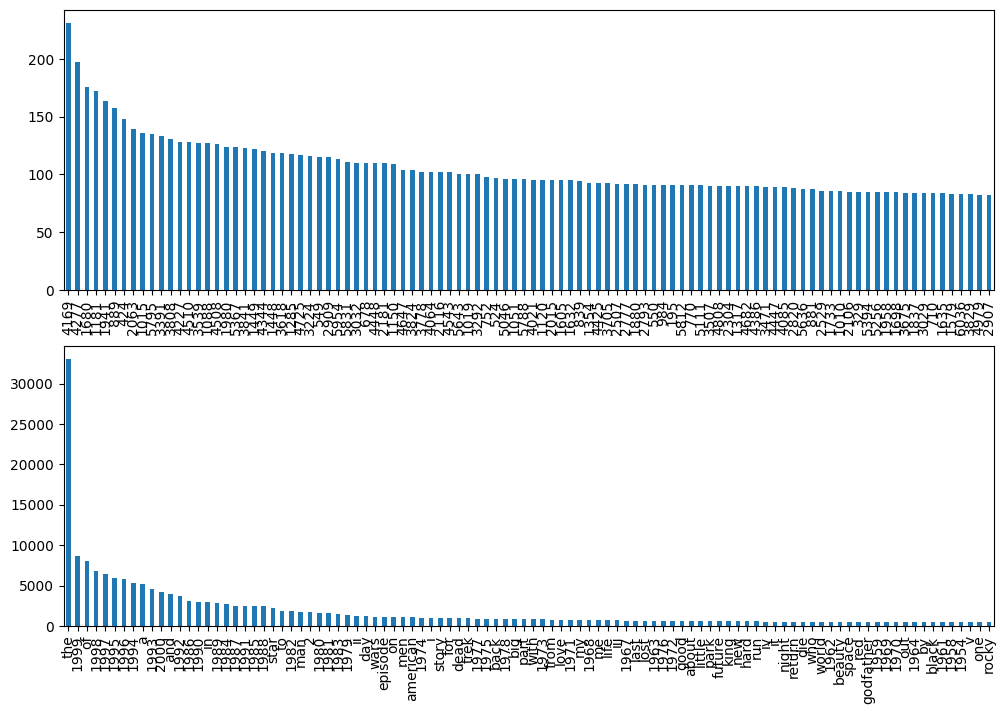

In [36]:
df = tfds.as_dataframe(raw_ratings_dataset.shuffle(buffer_size=10000, seed=2023).take(100000))

# Getting the 90th percentile of movie title lengths
movie_title_len = df["movie_title"].str.decode("utf-8").str.lower().str.replace(punctuation_regex, " ", regex=True).str.split().str.len().describe(percentiles=[0.9])
print(movie_title_len)

# Plotting frequencies of different IDs/tokens
user_id_ser = df["user_id"].str.decode("utf-8").value_counts().iloc[:100]
movie_title_ser = df["movie_title"].str.decode("utf-8").str.lower().str.replace(punctuation_regex, " ", regex=True).str.split().explode().value_counts().iloc[:100]


plt.subplots(2,1, figsize=(12, 8))

plt.subplot(2,1,1)
user_id_ser.plot.bar()

plt.subplot(2,1,2)
movie_title_ser.plot.bar()